# Previous code

In [201]:
import numpy as np

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [5]:
# remember to mount google drive

%cd "/content/drive/MyDrive/gpt spelled out"

/content/drive/MyDrive/gpt spelled out


In [6]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [7]:
# build vocabulary

chars = ["."] + sorted(list(set("".join(words))))
stoi = { s:i for i,s in enumerate(chars) } # string to integer
itos = { i:s for s,i in stoi.items() } # integer to string

In [8]:
context_length = 3

In [9]:
def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * context_length
    for ch in w + ".":
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

In [10]:
# build training, dev, test sets

import random

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [11]:
embed_dim = 10
hidden_layer_dim = 200

In [118]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, embed_dim), generator=g)

W1 = torch.randn((embed_dim*context_length, hidden_layer_dim), generator=g)
b1 = torch.randn(hidden_layer_dim, generator=g)

W2 = torch.randn((hidden_layer_dim, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters =[C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [119]:
batch_size = 32

In [120]:
n_steps = 30_000
lr = 0.1

loss_track = []

for k in range(1, n_steps+1):
  # get minibatch indices
  ix = torch.randint(0, len(Xtr), (batch_size,)) # pick batch_size random indices

  # forward pass
  emb = C[Xtr[ix]] # (b, context_length, embed_dim)
  cat = emb.view(-1, context_length*embed_dim) # (b, context_length*embed_dim)
  h = torch.tanh(cat @ W1 + b1) # (b, hidden_dim)
  logits = h @ W2 + b2 # (b, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  loss_track.append(loss.item())

  # print loss
  if k % 10_000 == 0 or k == 1:
    print(f"{k}/{n_steps} --> {loss.item()}")

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  lr = 0.1
  if k > 10_000:
    lr = 0.01
  if k > 25_000:
    lr = 0.001

  for p in parameters:
    p.data -= lr * p.grad

1/30000 --> 27.552431106567383
10000/30000 --> 3.0206992626190186
20000/30000 --> 1.9492460489273071
30000/30000 --> 1.8333394527435303


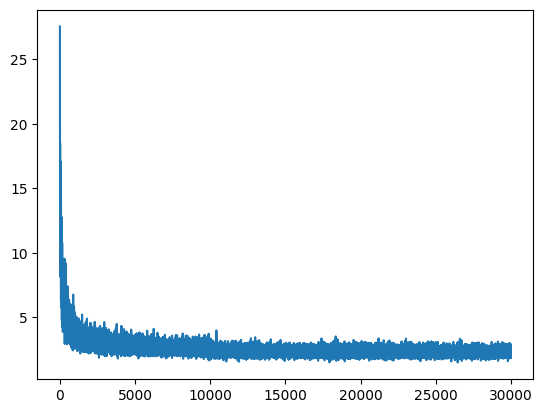

In [121]:
plt.plot(range(n_steps), loss_track)
plt.show()

In [122]:
@torch.no_grad()
def calc_loss(X, Y):
  emb = C[X] # (n, context_length, embed_dim)
  cat = emb.view(-1, embed_dim*context_length) # (n, context_length*embed_dim)
  h = torch.tanh(cat @ W1 + b1) # (n, 100)
  logits = h @ W2 + b2 # (n, 27)
  loss = F.cross_entropy(logits, Y)
  print(loss.item())

In [123]:
calc_loss(Xtr, Ytr)

2.298344373703003


In [124]:
calc_loss(Xdev, Ydev)

2.312575101852417


# Weight init problem

The previous initial loss is way too large ~ 26

This is because our weight initialization is bad.

In [91]:
embed_dim = 10
hidden_dim = 200

In [67]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, embed_dim), generator=g)

W1 = torch.randn((embed_dim*context_length, hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)

W2 = torch.randn((hidden_dim, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters =[C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [68]:
batch_size = 32

In [70]:
# get minibatch indices
ix = torch.randint(0, len(Xtr), (batch_size,)) # pick batch_size random indices

# forward pass
emb = C[Xtr[ix]] # (b, context_length, embed_dim)
cat = emb.view(-1, context_length*embed_dim) # (b, context_length*embed_dim)
h = torch.tanh(cat @ W1 + b1) # (b, hidden_dim)
logits = h @ W2 + b2 # (b, 27)
loss = F.cross_entropy(logits, Ytr[ix])
loss.item()

25.834211349487305

In [72]:
# We would expect, at initialization, that the model assigns uniform probability to all characters
# Let's see what the model is outputting as of now
logits[0]

tensor([ -4.7486, -16.1005, -15.6498,  22.0443,   9.9259,  10.2460, -17.5037,
          9.4386,   3.7419,   0.0329,  19.8093,  -5.2642,  -1.1271,  -2.5025,
         -6.7538, -27.6613, -19.9120, -17.8436,  -6.5749,   8.8605,   1.9987,
         10.4319,   1.8259,   7.8909,   1.8158,   4.0802,  -7.2507],
       grad_fn=<SelectBackward0>)

In [109]:
# As you can see, the model is really confident in some areas, this is definitely not a uniform distribution
# There is no reason for the model to have any pre-existing assumptions about the character probability distribution
# Therefore we would expect the logits, and therefore the probabilities, to be roughly uniform
logits = torch.Tensor([0, 0, 0, 0])
probs = F.softmax(logits, dim=0)
probs

tensor([0.2500, 0.2500, 0.2500, 0.2500])

In [112]:
labels = torch.tensor([0, 1, 0, 0]).float() # no matter what the label is, the loss will be the same
loss = F.cross_entropy(logits, labels)
loss

tensor(1.3863)

In [98]:
# Currently our logits are all over the place, and definitely not uniform
# So, what do we actually expect our loss to be?
# Well, if the initial output probability of the model is exactly uniform, then the loss would be:

import numpy as np

expected_loss = -np.log(1/27.0)
expected_loss

3.295836866004329

In [ ]:
# This is our expected loss because if the output probability distribution of the model was uniform, i.e. in thinks that any character is equally likely,
# then the probability of each character is 1/27. Thus no matter what the label is, because each character is equally likely, the output of the model for the
# correct label is still 1/27
# Thus calculating the negative log likelihood, we expect our loss to be output 3.295836866004329

In [77]:
# Okay, so given that we want roughly uniform logits, how can we accomplish this?
# Well, how do we calculate logits?

logits = h @ W2 + b2

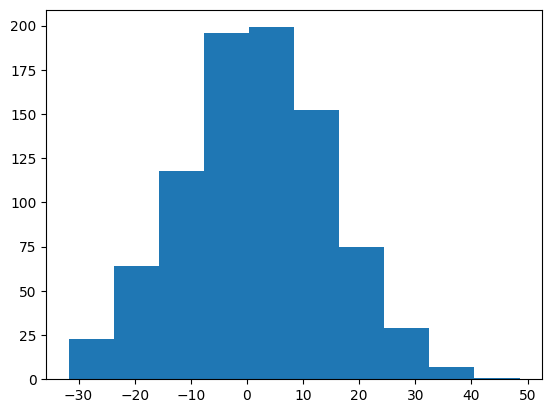

In [84]:
plt.hist(list(logits.view(-1).detach().numpy()));

In [85]:
# We would like our logits to be:

# 1) Roughly uniform
# 2) Closer to 0

# logits depend on W2 and b2, so we will have to adjust these

In [87]:
# First, let's initialize the bias to zero, there's no reason to give values to the bias as this adds entropy to the distribution
b2 = torch.zeros(27)

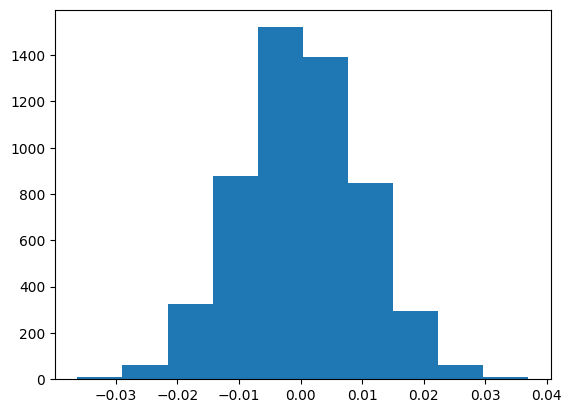

In [100]:
# To reduce the standard deviation/spread of the logits, i.e. to make them more centered around 0, we can just scale down the weights of W2
# This works because we are initializing the weights with Gaussian distribution, which has mean 0 and std 1.
# Thus by multiplying each value by some constant, we are just spreading (or squashing) the distribution
W2 = torch.randn((hidden_dim, 27)) * 0.01
# Now the distribution of the weights will have mean 0 and std 0.01

plt.hist(list(W2.view(-1)));

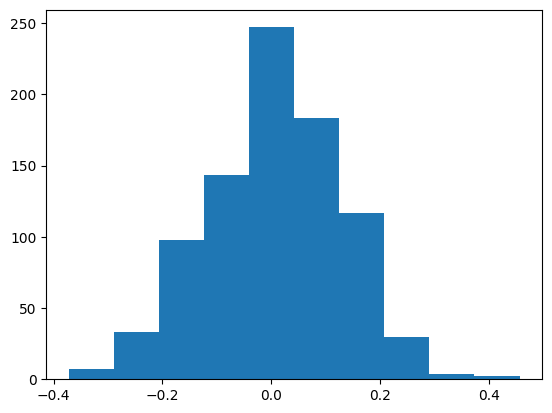

In [101]:
# Now, let's calculate and visualize our logits
logits = h @ W2 + b2
plt.hist(list(logits.view(-1).detach().numpy()));

In [94]:
# That looks much better
# Most of the logits are 0, which is good
# The rest of the logits are close to 0, which means the resulting probability distribution will be at least a bit more smoother

In [102]:
# Let's calculate our initial loss again
# Remember what the expected loss was for a completely uniform probability distribution

expected_loss

3.295836866004329

In [103]:
# Let's see if we get something similar

# Weight init fixed

In [125]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, embed_dim), generator=g)

W1 = torch.randn((embed_dim*context_length, hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)

W2 = torch.randn((hidden_dim, 27), generator=g) * 0.01 # scale down weights
b2 = torch.zeros(27) # init biases to 0
parameters =[C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [126]:
# get minibatch indices
ix = torch.randint(0, len(Xtr), (batch_size,)) # pick batch_size random indices

# forward pass
emb = C[Xtr[ix]] # (b, context_length, embed_dim)
cat = emb.view(-1, context_length*embed_dim) # (b, context_length*embed_dim)
h = torch.tanh(cat @ W1 + b1) # (b, hidden_dim)
logits = h @ W2 + b2 # (b, 27)
loss = F.cross_entropy(logits, Ytr[ix])
loss.item()

3.2997822761535645

In [127]:
# Nice, our initial loss is much closer to our expected loss than what is was before, which was around 26
# Let's train our model again

In [128]:
n_steps = 30_000
lr = 0.1

loss_track = []

for k in range(1, n_steps+1):
  # get minibatch indices
  ix = torch.randint(0, len(Xtr), (batch_size,)) # pick batch_size random indices

  # forward pass
  emb = C[Xtr[ix]] # (b, context_length, embed_dim)
  cat = emb.view(-1, context_length*embed_dim) # (b, context_length*embed_dim)
  h = torch.tanh(cat @ W1 + b1) # (b, hidden_dim)
  logits = h @ W2 + b2 # (b, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  loss_track.append(loss.item())

  # print loss
  if k % 10_000 == 0 or k == 1:
    print(f"{k}/{n_steps} --> {loss.item()}")

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  lr = 0.1
  if k > 10_000:
    lr = 0.01
  if k > 25_000:
    lr = 0.001

  for p in parameters:
    p.data -= lr * p.grad

1/30000 --> 3.299415111541748
10000/30000 --> 2.574401378631592
20000/30000 --> 2.188972234725952
30000/30000 --> 1.8194150924682617


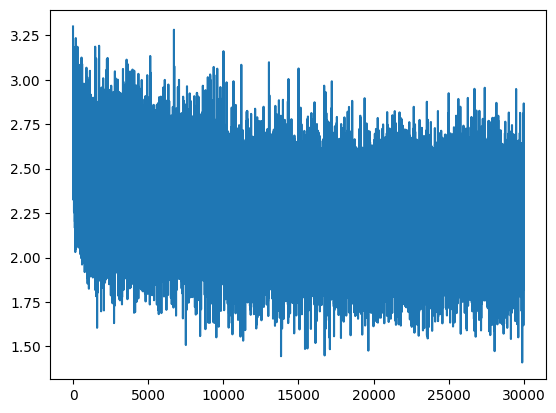

In [129]:
plt.plot(range(n_steps), loss_track)
plt.show()

In [ ]:
# Notice how our loss graph doesn't have that steep drop at the start, which the previous experiment had
# This is because our weight init is much better, and our model is starting at much more based, grounded position

In [115]:
calc_loss(Xtr, Ytr)

2.1693763732910156


In [116]:
calc_loss(Xdev, Ydev)

2.1941957473754883


In [130]:
# That was a huge improvement from last time!
# This is improvement is because the model is now spending less time trying to squash down the weights into a manageable domain, and more time actually working
# on the network

# Tanh problem

In [132]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, embed_dim), generator=g)

W1 = torch.randn((embed_dim*context_length, hidden_dim), generator=g)
b1 = torch.randn(hidden_dim, generator=g)

W2 = torch.randn((hidden_dim, 27), generator=g) * 0.01 # scale down weights
b2 = torch.zeros(27) # init biases to 0
parameters =[C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [139]:
# forward pass
emb = C[Xtr[ix]]
cat = emb.view(-1, context_length*embed_dim)
hpreact = cat @ W1 + b1 # new variable!!
h = torch.tanh(hpreact)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr[ix])

In [140]:
h

tensor([[ 0.9996, -0.9999,  0.6627,  ..., -1.0000,  0.9824,  1.0000],
        [ 0.7166, -0.8534,  0.3708,  ...,  0.9956, -1.0000, -0.8916],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        ...,
        [-0.9620, -1.0000, -1.0000,  ..., -0.1601, -1.0000, -1.0000],
        [-1.0000,  0.9990, -1.0000,  ...,  0.9973,  0.7236,  0.9981],
        [ 0.9999, -0.9065, -0.9873,  ..., -1.0000,  0.3119,  1.0000]],
       grad_fn=<TanhBackward0>)

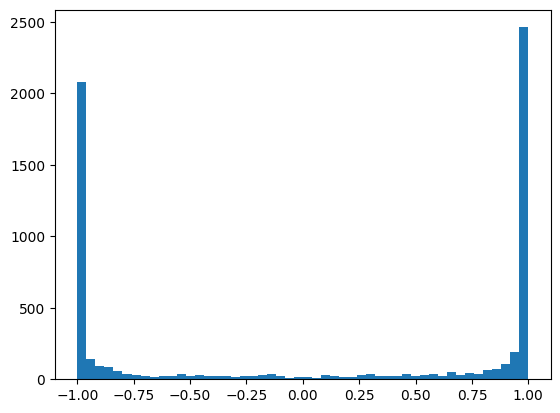

In [141]:
# Notice how most of the values are either 1, -1 or close to these extremes
# Let's visualize the histogram

plt.hist(h.view(-1).tolist(), 50);

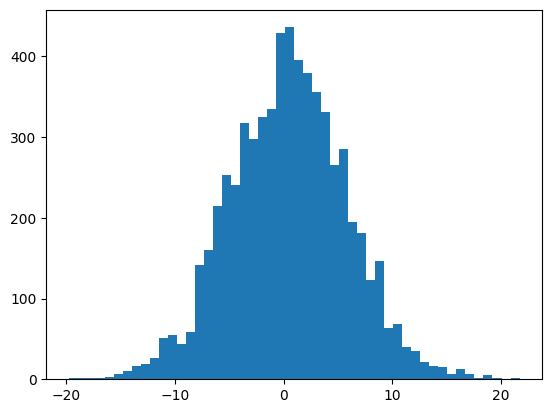

In [143]:
# Why is this?
# This is happening because the tanh function squishes its inputs into the range [-1, 1]
# It seems that most of the inputs are either very negative or very positive
# Let's take a look

plt.hist(hpreact.view(-1).tolist(), 50);

In [146]:
# Yep, there's a lot variation there
# Just for reference:

preacts = range(10) # preacts = pre activations
for x in preacts:
  print(f"{x=} | t={np.tanh(x)}")

x=0 | t=0.0
x=1 | t=0.7615941559557649
x=2 | t=0.9640275800758169
x=3 | t=0.9950547536867305
x=4 | t=0.999329299739067
x=5 | t=0.9999092042625951
x=6 | t=0.9999877116507956
x=7 | t=0.9999983369439447
x=8 | t=0.9999997749296758
x=9 | t=0.9999999695400409


In [ ]:
# Even at x=2 (or x=-2), the tanh already goes up to 0.96 (or -0.96)
# Why is this a problem?

In [147]:
# Well, the problem comes during back propagation
# The gradient of t=tanh(x) happens to be (1-t**2)

# If t=1, then the grad = (1-1**2) = 0
# If t=-1, then the grad = (1-(-1)**2) = 0

# Since the gradient is 0, it is essentially cancelling out the gradients which are trying to flow backwards
# This means that the tanh neurons don't actually learn, and since the gradients become 0, the previous layers also learn very little

In [148]:
# So our problem is that the inputs to the tanh are way to spread out, causing the tanh function to pushed to the extremes of 1 and -1
# So to fix this, we need to make the inputs to the tanh function closer to 0
# What are the inputs to the tanh function again?

hpreact

tensor([[ 4.2274, -5.1272,  0.7977,  ..., -6.6219,  2.3632, 12.0687],
        [ 0.9007, -1.2685,  0.3894,  ...,  3.0577, -5.6837, -1.4296],
        [-9.8810,  1.9506, -0.1427,  ..., -0.1273,  5.3983,  7.5101],
        ...,
        [-1.9716, -5.8194, -8.0808,  ..., -0.1615, -6.1296, -6.2876],
        [-6.3541,  3.8031, -8.0774,  ...,  3.2954,  0.9153,  3.4712],
        [ 5.2369, -1.5076, -2.5246,  ..., -7.2467,  0.3226, 11.4732]],
       grad_fn=<AddBackward0>)

In [150]:
hpreact = cat @ W1 + b1

In [151]:
# We already know how to make hpreact closer to 0, we just scale down the weights and set the biases to 0

In [160]:
W1 = torch.randn((embed_dim*context_length, hidden_dim), generator=g) * 0.02 # scale down weights, std=0.02
b1 = torch.zeros(hidden_dim) # set biases to zero

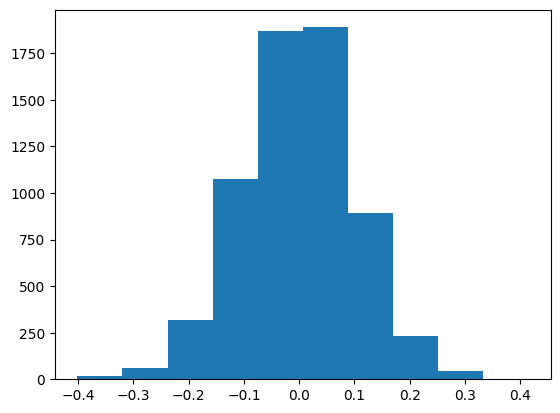

In [161]:
# Let's calculate and visualize our preactivations

hpreact = cat @ W1 + b1

plt.hist(hpreact.view(-1).tolist());

In [162]:
# Just for reference:

preacts = [0, 0.1, 0.2, 0.3, 0.4]
for x in preacts:
  print(f"{x=} | t={np.tanh(x)}")

x=0 | t=0.0
x=0.1 | t=0.09966799462495582
x=0.2 | t=0.197375320224904
x=0.3 | t=0.2913126124515909
x=0.4 | t=0.3799489622552249


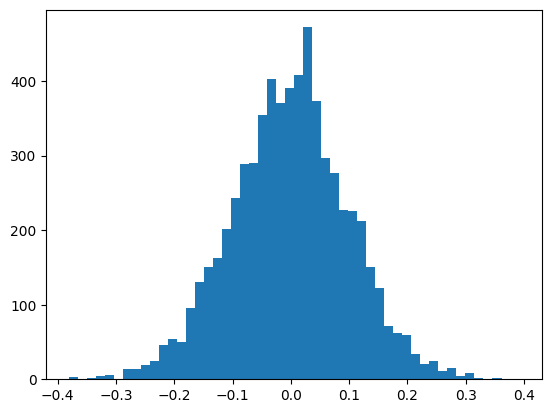

In [163]:
# Looks like our tanh activations are much more closer to 0, and definitely not near the extremes of -1 and 1

# Let's recalculate our tanh activations for the network

h = torch.tanh(hpreact)

plt.hist(h.view(-1).tolist(), 50);

In [ ]:
# Nice! We don't have any activations at the extremes!
# You might even notice that the tanh distribution looks pretty similar to the preactivation distribution
# This is because around the domain [-0.5, 0.5], tanh actually looks like a linear function

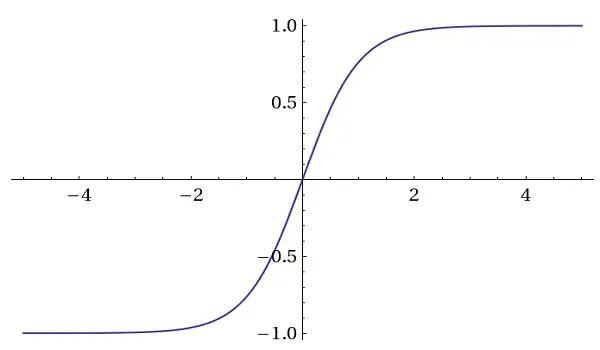

In [ ]:
# Okay, let's use our new weights to optimize our neural network

# Tanh problem fixed

In [196]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, embed_dim), generator=g)

# W1 = torch.randn((embed_dim*context_length, hidden_dim), generator=g)
# b1 = torch.randn(hidden_dim, generator=g)

W1 = torch.randn((embed_dim*context_length, hidden_dim), generator=g) * 0.02 # scale down weights
b1 = torch.randn(hidden_dim, generator=g) * 0.01 # scale down biases, not clamping to 0, just to add a little bit of entropy

W2 = torch.randn((hidden_dim, 27), generator=g) * 0.01 # scale down weights
b2 = torch.zeros(27) # init biases to 0
parameters =[C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

In [197]:
n_steps = 100_000 # increased no. of steps
batch_size = 128 # increased the batch size to streamline updates (low batch size causes a noisy loss graph)
lr = 0.1

loss_track = []

for k in range(1, n_steps+1):
  # get minibatch indices
  ix = torch.randint(0, len(Xtr), (batch_size,)) # pick batch_size random indices

  # forward pass
  emb = C[Xtr[ix]] # (b, context_length, embed_dim)
  cat = emb.view(-1, context_length*embed_dim) # (b, context_length*embed_dim)
  h = torch.tanh(cat @ W1 + b1) # (b, hidden_dim)
  logits = h @ W2 + b2 # (b, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  loss_track.append(loss.item())

  # print loss
  if k % 10_000 == 0 or k == 1:
    print(f"{k}/{n_steps} --> {loss.item()}")

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update parameters
  lr = 0.1
  if k > 50_000:
    lr = 0.01
  if k > 75_000:
    lr = 0.001

  for p in parameters:
    p.data -= lr * p.grad

1/100000 --> 3.295149803161621
10000/100000 --> 2.3469269275665283
20000/100000 --> 2.1159491539001465
30000/100000 --> 2.1715967655181885
40000/100000 --> 2.226206064224243
50000/100000 --> 2.09708571434021
60000/100000 --> 2.3058831691741943
70000/100000 --> 2.192918062210083
80000/100000 --> 1.9453812837600708
90000/100000 --> 2.0305793285369873
100000/100000 --> 2.2624826431274414


In [198]:
calc_loss(Xtr, Ytr)

2.1235158443450928


In [199]:
calc_loss(Xdev, Ydev)

2.148545980453491


In [ ]:
# Nice! That's much better than last time, which was around 2.19 dev loss

# Pytorch-ish-ification

In [202]:
generator = torch.Generator().manual_seed(42)

In [203]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [204]:
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps # to avoid divisionbyzero error when scaling
    self.momentum = momentum # to compute running average
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (stored with a running momentum update)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    # update the bufers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

In [205]:
class Tanh:

  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

In [211]:
n_embed = 10
n_hidden = 100
vocab_size = 27

C = torch.randn((vocab_size, n_embed), generator=g)

layers = [
    Linear(n_embed * context_length, n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), Tanh(),
    Linear(                n_hidden, n_hidden), Tanh(),
    Linear(                n_hidden, vocab_size)
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3 # only because we are using tanh

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

46497


In [212]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
  # construct minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data -= lr * p.grad

  # track stats
  if i % 10_000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000: 3.3126
  10000/ 200000: 2.2132
  20000/ 200000: 1.8234
  30000/ 200000: 2.1698
  40000/ 200000: 1.9973
  50000/ 200000: 2.2576
  60000/ 200000: 1.9872
  70000/ 200000: 2.0395
  80000/ 200000: 1.5493
  90000/ 200000: 1.8756
 100000/ 200000: 1.9737
 110000/ 200000: 1.8775
 120000/ 200000: 1.9993
 130000/ 200000: 2.2667
 140000/ 200000: 1.9374
 150000/ 200000: 1.9967
 160000/ 200000: 1.9388
 170000/ 200000: 2.1124
 180000/ 200000: 2.0461
 190000/ 200000: 1.9959
